<a href="https://www.kaggle.com/code/blohorn/llm-detect-generated-text?scriptVersionId=154886468" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [130]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv


In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [132]:
%env TRANSFORMERS_OFFLINE=1
%env HF_DATASETS_OFFLINE=1

env: TRANSFORMERS_OFFLINE=1
env: HF_DATASETS_OFFLINE=1


In [133]:
train_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv') 
test_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
sample = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

In [134]:
sample

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


In [135]:
print(train_df.shape)
print(test_df.shape)
print(sample.shape)

(1378, 4)
(3, 3)
(3, 2)


In [136]:
train_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [137]:
train_ext = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
train_df.rename(columns={"generated": "label"}, inplace=True)

In [138]:
df_final = pd.concat([train_df[["text",'label']], train_ext[["text","label"]]])

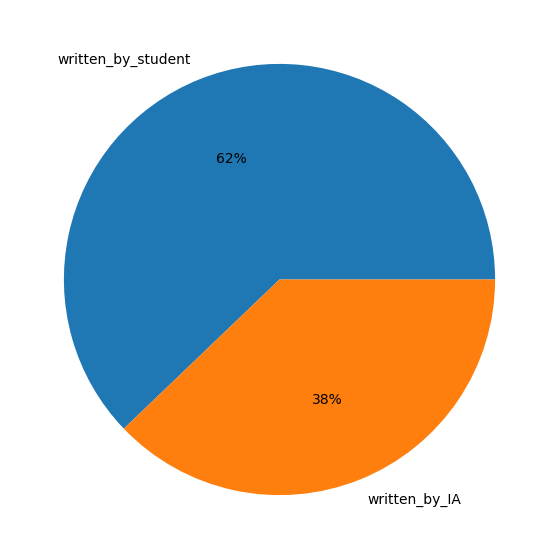

In [139]:
labels = {'written_by_student' : '0', 'written_by_IA' : '1'}
plt.figure(figsize=(7,7))
plt.pie(df_final['label'].value_counts(), labels=labels, autopct='%.0f%%')
plt.show()

In [140]:
df_final["text_length"] =  df_final["text"].apply(lambda x : len(x.split()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.98, 'Distribution de la taille de mots par dissertations - Train dataset')

<Figure size 4000x5000 with 0 Axes>

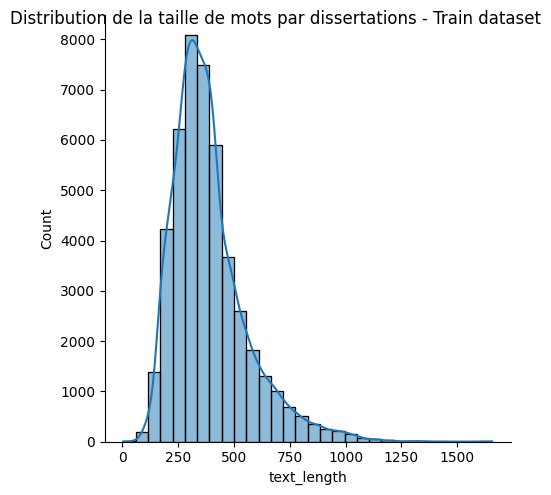

In [141]:
fig = plt.figure(figsize=(40,50))
plot = sns.displot(data=df_final,
                 x="text_length", bins=30, kde=True)
plot.fig.suptitle("Distribution de la taille de mots par dissertations - Train dataset")

In [142]:
from transformers import pipeline

In [143]:
from transformers import AutoTokenizer

# Tokenizer

In [144]:
from datasets import Dataset

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

save_path = 'distilbertuncases_model'
!mkdir {save_path}
tokenizer.save_pretrained(save_path)

In [145]:
save_path = '/kaggle/working/distilbertuncases_model'
tokenizer = AutoTokenizer.from_pretrained(save_path)

In [146]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [147]:
def pipeline(dataframe):
    """
    Prepares the dataframe so that it can be given to the transformer model
    
    in -> pandas dataframe
    out -> tokenized dataset (columns = text, label, input, attention)
    """    
    # This step isn't mentioned anywhere but is vital as Transformers library only seems to work with this Dataset data type
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [148]:
traindf, testdf = train_test_split(df_final[['text', 'label']], 
                                    test_size = 0.2, random_state = 42)

In [149]:
tokenized_train = pipeline(traindf)
tokenized_test = pipeline(testdf)

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [150]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 36996
})

In [151]:
tokenized_test

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 9250
})

In [152]:
from transformers import DataCollatorWithPadding

In [153]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [154]:
id2label = {0: "Write by student", 1: "Write by IA"}
label2id = {"Write by student": 0, "Write by IA": 1}

In [155]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [156]:
model = AutoModelForSequenceClassification.from_pretrained(save_path, num_labels=2, id2label=id2label, label2id=label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
)


model.save_pretrained(save_path)

In [157]:
training_args = TrainingArguments(
    output_dir="my_IA_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy = 'epoch',
    load_best_model_at_end=True,
    push_to_hub=False,
    optim="adamw_torch",
    report_to="none"
)


In [158]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=predictions)
    return {"accuracy": accuracy}

In [159]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [160]:
%time trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.029000,0.079449,0.983892
2,0.007700,0.017081,0.996432


CPU times: user 37min 8s, sys: 4.73 s, total: 37min 13s
Wall time: 37min 10s


TrainOutput(global_step=4626, training_loss=0.028544903806520652, metrics={'train_runtime': 2229.8588, 'train_samples_per_second': 33.182, 'train_steps_per_second': 2.075, 'total_flos': 9800025084301248.0, 'train_loss': 0.028544903806520652, 'epoch': 2.0})

In [161]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 36996
})

In [162]:
token_test = pipeline(test_df)
print(token_test)



/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['id', 'prompt_id', 'input_ids', 'attention_mask'],
    num_rows: 3
})


In [163]:
token_test = token_test.remove_columns('prompt_id')

In [164]:
preds = trainer.predict(token_test)

In [165]:
preds

PredictionOutput(predictions=array([[-0.23581183,  0.5347051 ],
       [-0.20793141,  0.57625484],
       [-0.07459433,  0.37255555]], dtype=float32), label_ids=None, metrics={'test_runtime': 0.0112, 'test_samples_per_second': 268.035, 'test_steps_per_second': 89.345})

In [166]:
preds_flat = [np.argmax(x) for x in preds[0]]

preds_flat

[1, 1, 1]

In [167]:
test_df

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [168]:
t= test_df.copy()

In [169]:
t['generated'] = preds_flat

In [170]:
t

,id,prompt_id,text,generated
0,0000aaaa,2,Aaa bbb ccc.,1
1,1111bbbb,3,Bbb ccc ddd.,1
2,2222cccc,4,CCC ddd eee.,1


In [171]:
t = t[["id", "generated"]]

In [172]:
t.to_csv('submission.csv', index=False)